In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, accuracy_score, precision_score, f1_score, roc_auc_score
import optuna

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("c:/Users/REVAN/Documents/ML/dataset_candidate_credit_line/application_record.csv")
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
DD = data.drop(columns=['ID', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_MOBIL', 'OCCUPATION_TYPE'])
DD.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,M,Y,Y,0,427500.0,Working,Rented apartment,-12005,-4542,1,0,0,2.0
1,M,Y,Y,0,427500.0,Working,Rented apartment,-12005,-4542,1,0,0,2.0
2,M,Y,Y,0,112500.0,Working,House / apartment,-21474,-1134,0,0,0,2.0
3,F,N,Y,0,270000.0,Commercial associate,House / apartment,-19110,-3051,0,1,1,1.0
4,F,N,Y,0,270000.0,Commercial associate,House / apartment,-19110,-3051,0,1,1,1.0


In [ ]:
categorical_cols = DD.select_dtypes(include=['object']).columns

label_encoders = {}  
for col in DD.columns:
    le = LabelEncoder()
    DD[col] = le.fit_transform(DD[col])  
    label_encoders[col] = le  


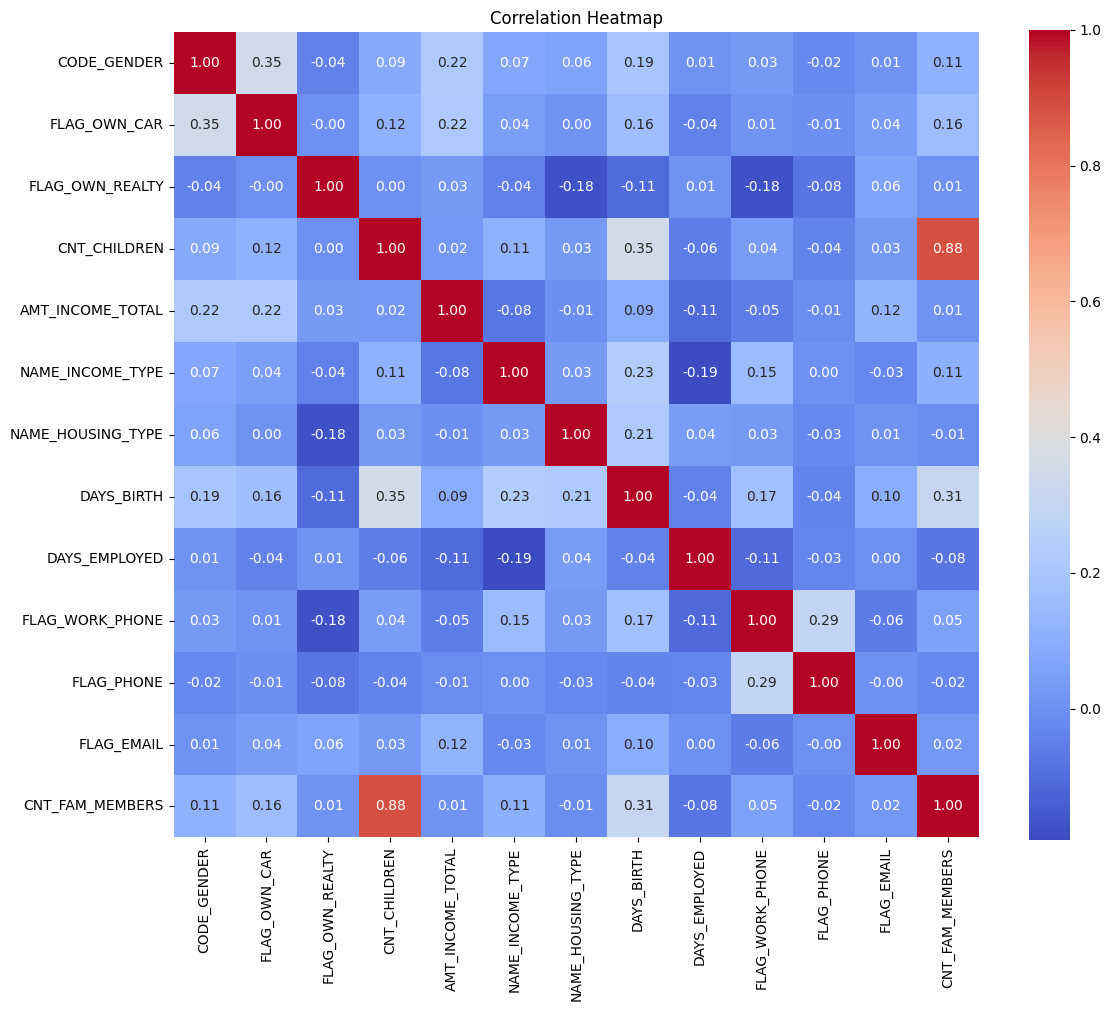

In [5]:
plt.figure(figsize=(12, 10))
korelasi_EDA = DD.corr()
sns.heatmap(korelasi_EDA, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



In [6]:
data['label'] = (
    (data['AMT_INCOME_TOTAL'] >= 250000).astype(int) &
    (data['NAME_HOUSING_TYPE'] != 'Rented apartment').astype(int) &
    (data['NAME_INCOME_TYPE'] != 'Pensioner').astype(int)
).astype(int)

X = DD.drop(['AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE'], axis = 1)
Y = data['label']

latih_x, uji_x, latih_y, uji_y = train_test_split(X, Y, test_size = 0.3, random_state = 15)

skala = StandardScaler()
skala_latih_x = skala.fit_transform(latih_x)
skala_uji_x = skala.transform(uji_x)

In [7]:
def objective(uji):
    params = {
        'n_estimators': uji.suggest_int('n_estimators', 100, 300),
        'max_depth': uji.suggest_int('max_depth', 5, 15),
        'min_samples_split': uji.suggest_int('min_samples_split', 3, 6),
        'min_samples_leaf': uji.suggest_int('min_samples_leaf', 2, 5),
        'max_features': uji.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 15,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    hasil = cross_val_score(model, skala_latih_x, latih_y, scoring='roc_auc', cv=crossvalidation, n_jobs=-1)
    
    return hasil.mean()



In [8]:
ujicoba = optuna.create_study(direction='maximize')
ujicoba.optimize(objective, n_trials=30, timeout=600)  

modelterbaik = RandomForestClassifier(**ujicoba.best_params, random_state=15, n_jobs=-1)
modelterbaik.fit(skala_latih_x, latih_y)

print("Nilai terbaik ROC AUC:", ujicoba.best_value)
print("Parameters terbaik dari tuning:", ujicoba.best_params)

[I 2025-04-06 21:06:27,395] A new study created in memory with name: no-name-9af72f30-312c-414a-b8a7-6baa60aca945
[I 2025-04-06 21:07:54,000] Trial 0 finished with value: 0.7285490272253463 and parameters: {'n_estimators': 166, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7285490272253463.
[I 2025-04-06 21:10:39,035] Trial 1 finished with value: 0.8253633197330126 and parameters: {'n_estimators': 143, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8253633197330126.
[I 2025-04-06 21:12:35,873] Trial 2 finished with value: 0.7420629760389341 and parameters: {'n_estimators': 135, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8253633197330126.
[I 2025-04-06 21:14:07,909] Trial 3 finished with value: 0.7346138490296256 and parameters: {'n_estimators': 127, 'max_depth': 6, 'min_

Nilai terbaik ROC AUC: 0.8253633197330126
Parameters terbaik dari tuning: {'n_estimators': 143, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [9]:
prediksi = modelterbaik.predict(skala_uji_x)

In [10]:
print("\n=== Classification Report ===")
print(classification_report(uji_y, prediksi, digits=4))

f1 = f1_score(uji_y, prediksi, average='weighted')
print(f"\nMacro F1 Score: {f1:.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8460    0.9995    0.9164    110204
           1     0.9578    0.0616    0.1158     21364

    accuracy                         0.8472    131568
   macro avg     0.9019    0.5305    0.5161    131568
weighted avg     0.8642    0.8472    0.7864    131568


Macro F1 Score: 0.7864


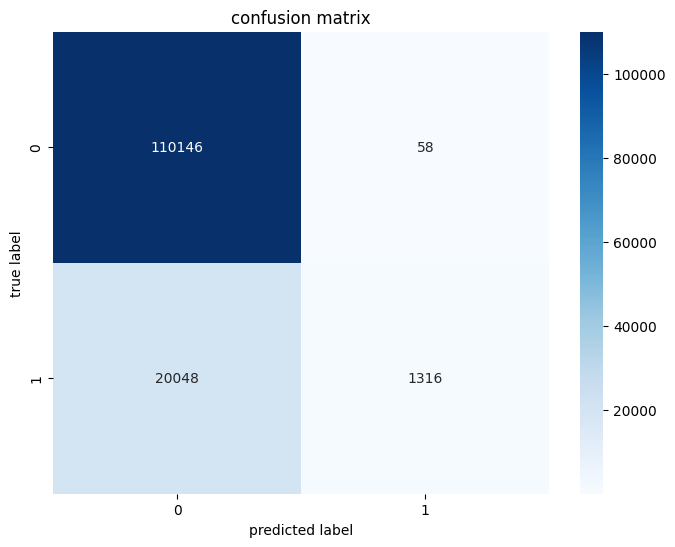

In [11]:
plt.figure(figsize=(8, 6))
grafik = confusion_matrix(uji_y, prediksi)
sns.heatmap(grafik, annot = True, fmt='d', cmap = 'Blues')
plt.title('confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

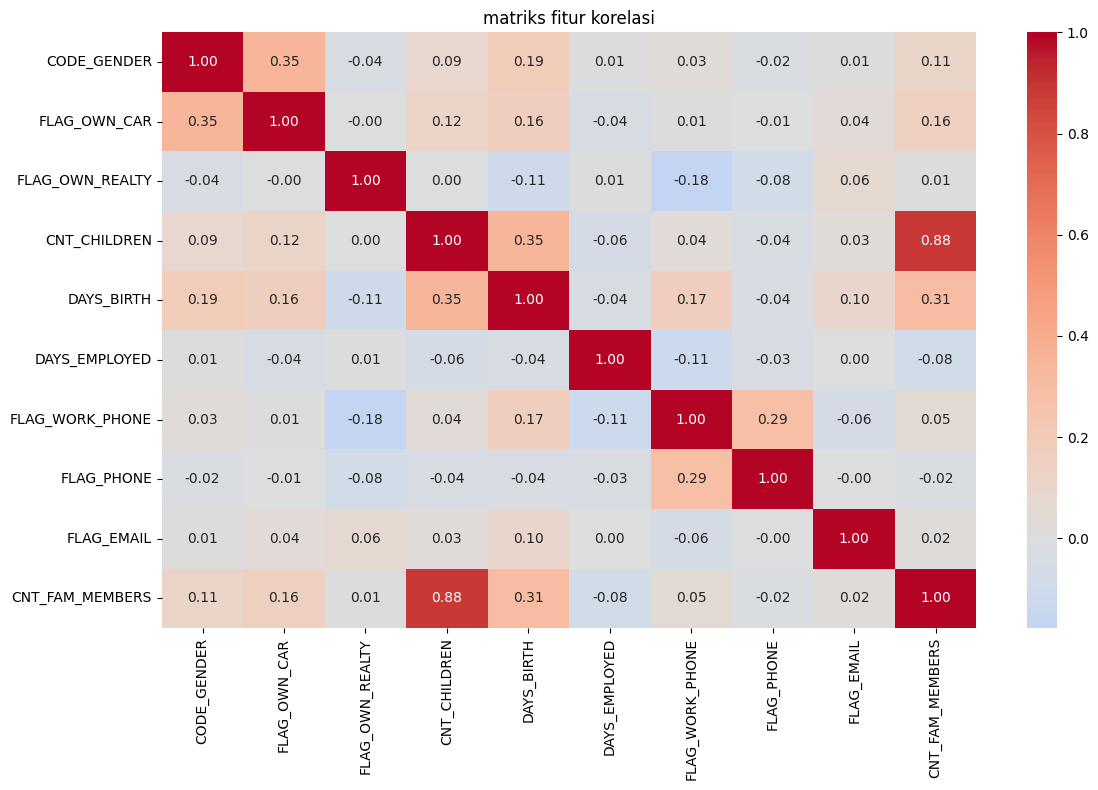

In [12]:
plt.figure(figsize=(12, 8))
matrikskorelasi = X.corr()
sns.heatmap(matrikskorelasi, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('matriks fitur korelasi')
plt.tight_layout()
plt.show()

In [13]:
pred_probabilitas = modelterbaik.predict_proba(skala_uji_x)[:,1]
fpr, tpr, _ = roc_curve(uji_y, pred_probabilitas)
roc_auc = auc(fpr, tpr)

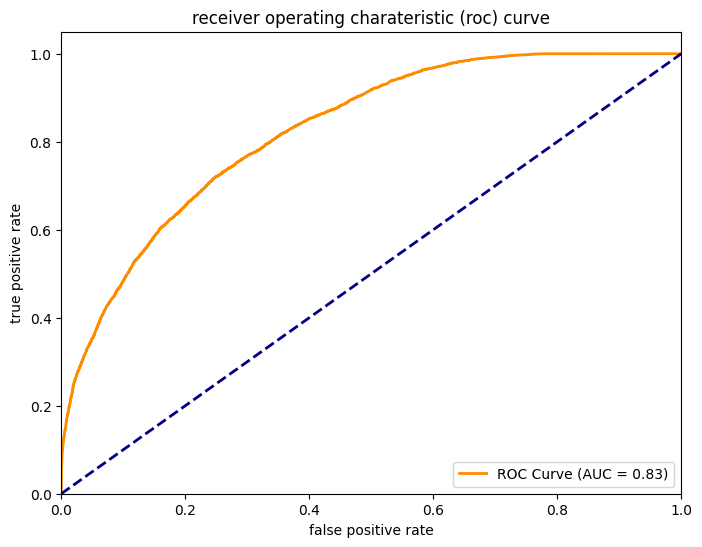

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating charateristic (roc) curve')
plt.legend(loc="lower right")
plt.show()